# Import Libraries

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocessing and loading the MNIST dataset

## Check CUDA

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


## MNIST Dataset Mean and Std Dev

In [3]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

loader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)
images, _ = next(iter(loader))
print(images.mean(), images.std())

train_mean = images.mean()
train_std = images.std()

tensor(0.1307) tensor(0.3081)


## Load Data

In [6]:
# Transform: convert to tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((train_mean,), (train_std,))  # mean and standard deviation as calculated above
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)


# Visualize Data

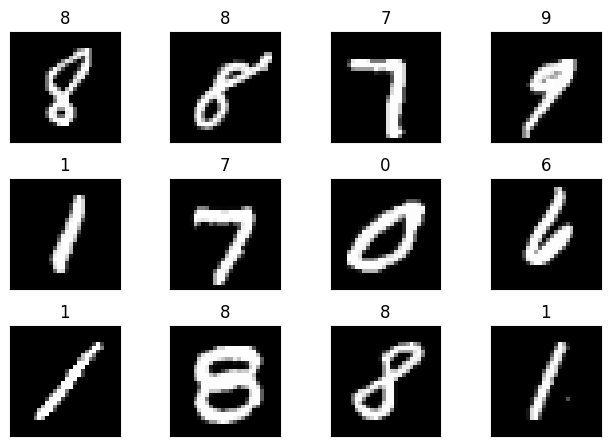

In [7]:
batch_data, batch_label = next(iter(trainloader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

# Modelling

## Model Architecture

In [45]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)

        x = self.gap(x)

        x = x.view(-1, 32)
        x = self.dropout(x)
        x = self.fc(x)
        return x

## Model Training (20 Epochs)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

# Lists to store training statistics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop for 20 epochs
for epoch in range(20):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    scheduler.step()
    
    # Calculate training metrics
    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    
    # Evaluation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    # Calculate test metrics
    test_loss = test_loss / len(testloader)
    test_accuracy = 100 * correct_test / total_test
    
    # Store statistics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Print epoch statistics
    print(f'Epoch [{epoch+1}/20] - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

print("Training completed!")

Epoch [1/20] - Train Loss: 0.3766, Train Acc: 91.83% - Test Loss: 0.0939, Test Acc: 97.80%
Epoch [2/20] - Train Loss: 0.0692, Train Acc: 98.23% - Test Loss: 0.0642, Test Acc: 98.11%
Epoch [3/20] - Train Loss: 0.0500, Train Acc: 98.61% - Test Loss: 0.0682, Test Acc: 97.85%
Epoch [4/20] - Train Loss: 0.0397, Train Acc: 98.88% - Test Loss: 0.0299, Test Acc: 99.01%
Epoch [5/20] - Train Loss: 0.0334, Train Acc: 99.02% - Test Loss: 0.0298, Test Acc: 99.08%
Epoch [6/20] - Train Loss: 0.0299, Train Acc: 99.07% - Test Loss: 0.0266, Test Acc: 99.25%
Epoch [7/20] - Train Loss: 0.0264, Train Acc: 99.22% - Test Loss: 0.0253, Test Acc: 99.16%
Epoch [8/20] - Train Loss: 0.0226, Train Acc: 99.32% - Test Loss: 0.0306, Test Acc: 99.01%
Epoch [9/20] - Train Loss: 0.0204, Train Acc: 99.38% - Test Loss: 0.0223, Test Acc: 99.23%
Epoch [10/20] - Train Loss: 0.0169, Train Acc: 99.50% - Test Loss: 0.0262, Test Acc: 99.13%
Epoch [11/20] - Train Loss: 0.0148, Train Acc: 99.55% - Test Loss: 0.0199, Test Acc: 99.4

## Model Performance

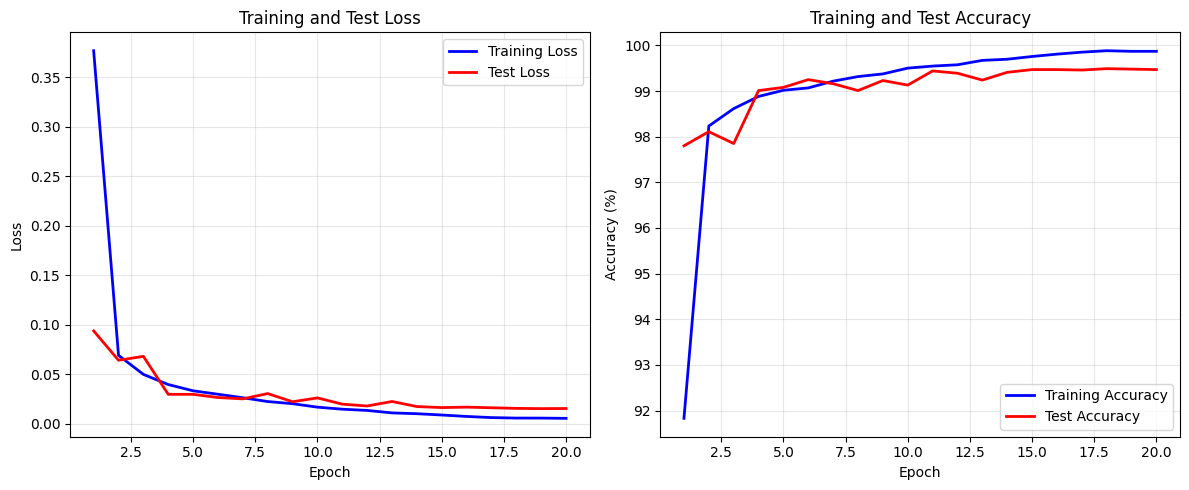


Final Results:
Training Loss: 0.0056
Training Accuracy: 99.87%
Test Loss: 0.0155
Test Accuracy: 99.47%


In [47]:
# Plotting training and test loss
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, 21), test_losses, 'r-', label='Test Loss', linewidth=2)
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(range(1, 21), test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print(f"\nFinal Results:")
print(f"Training Loss: {train_losses[-1]:.4f}")
print(f"Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Test Loss: {test_losses[-1]:.4f}")
print(f"Test Accuracy: {test_accuracies[-1]:.2f}%")

## Model Summary

In [48]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             584
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           1,168
       BatchNorm2d-7           [-1, 16, 14, 14]              32
            Conv2d-8           [-1, 16, 14, 14]           2,320
       BatchNorm2d-9           [-1, 16, 14, 14]              32
        MaxPool2d-10             [-1, 16, 7, 7]               0
           Conv2d-11             [-1, 32, 7, 7]           4,640
      BatchNorm2d-12             [-1, 32, 7, 7]              64
           Conv2d-13             [-1, 32, 7, 7]           9,248
      BatchNorm2d-14             [-1, 3